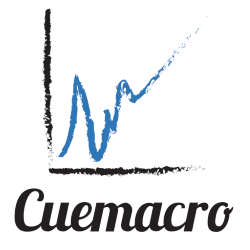

# Compliance and other more involved TCA calculations

**Saeed Amen / Founder of Cuemacro**

https://www.cuemacro.com / saeed@cuemacro.com / @saeedamenfx / All material is copyright Cuemacro / 2020

tcapy is a transaction cost analysis library in Python and one of the first open source TCA library. Typically, internal solutions can cost hundreds of thousands of dollars to develop and maintain. Using external services to do TCA also often have a licence cost.

This notebook assumes that you have already 
* installed it by following the instructions [here](https://github.com/cuemacro/tcapy/blob/master/INSTALL.md)) 
* read the introductory tcapy notebook [here](https://github.com/cuemacro/tcapy/blob/master/tcapy_notebooks/introducing_tcapy.ipynb)

In this notebook, we show how we can do more involved TCA calculations with tcapy. We will show users how to construct Python based queries to:

* Calculate notionals executed with each LP (liquidity provider)
* Flag trades which have outlying slippage

We shall also show you how to do to use some of the lower level parts of tcapy.

## Benchmark machines

For reference, the benchmark times quoted in the text are for the following hardware setup, which is designed to replicate a typical environment, where databases are running on a different system. In our case, we are running on Windows and WSL/Ubuntu on our primary machine. This setup is the best of both worlds, allowing us to use features like Celery and Dash/web GUI undex Linux, but still using Windows, so we could also interact with applications like Excel easily. Note, that the times we quote are from running once (in practice, we should take an average over many runs).

tcapy is running on
* Processor: Intel(R) Core(TM) i9-7940X CPU @ 3.10GHz, 14 Core(s)
* Memory: 64 GB RAM
* Hard disk: NVMe m.2 SSD
* OS: Windows Version 10.0.18362 and WSL/Windows Subsystem for Linux (Ubuntu 18.04) running Celery/Redis/Memcached backend

Databases are running on (Arctic/MongoDB 3.6.5 for market tick data and Microsoft SQL Server 14.0.2027)
* Intel(R) Xeon(R) CPU E3-1505M v6 @ 3.00GHz, 4 Core(s)
* Memory: 32 GB RAM and 
* Hard disk: NVMe m.2 SSD
* OS: Windows Version 10.0.17763

Our first step is to add the tcapy library to our `PYTHONPATH`. You may need to change these lines. Note, that in our setup, we are running the Jupyter notebook on Windows, and the backend Celery workers on Linux. If you are running everything in the same environment, the paths are likely to be same.

In [1]:
import sys
import os

windows_tcapy_path = 'e:/Remote/tcapy' # Windows platform
linux_tcapy_path = '/home/tcapyuser/cuemacro/tcapy' # Linux platform
local_test_data_path = 'e:/Remote/tcapy/tests_harness_data/' # Windows platform
remote_test_data_path = '/home/tcapyuser/cuemacro/tcapy/tests_harness_data/' # WSL drive

# Assuming the front end is on Linux
sys.path.insert(0, windows_tcapy_path)

If the Python path now includes tcapy, we can do all the imports from it, that we'll need later. We'll also import all the other Python libraries we'll use.

In [2]:
from collections import OrderedDict

# This is the entry point for our TCA analysis
from tcapy.analysis.tcaengine import TCAEngineImpl

# To construct the parameters for our TCA calculation
from tcapy.analysis.tcarequest import TCARequest

# To access trade and market data
from tcapy.data.databasesource import DatabaseSourceCSVBinary, \
    DatabaseSourceDataFrame, DatabaseSourceDukascopy

# Import all the metrics and benchmarks we'll use
from tcapy.analysis.algos.benchmark import BenchmarkArrival, BenchmarkSpreadToMid
from tcapy.analysis.algos.metric import MetricSlippage, MetricTransientMarketImpact

# To aggregate the TCA results
from tcapy.analysis.algos.resultsform import TimelineResultsForm, DistResultsForm, \
    BarResultsForm, TableResultsForm, JoinTables

# To help display the output of a TCA calculation
from tcapy.vis.tcaresults import TCAResults
from tcapy.vis.report.tcareport import TCAReport
from tcapy.vis.displaylisteners import PlotRender

# General classes
from tcapy.conf.constants import Constants
from tcapy.util.mediator import Mediator

# Prevent requests from displaying debug messages for certain libraries
import logging

logging.getLogger("findatapy").setLevel(logging.WARNING)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# For plotting later
import plotly.io as pio

# For interactive plots (but these disappear when we reopen Jupyter)
pio.renderers.default = "notebook" 

# For static plots, need Orca (but might not work properly on WSL)
# pio.renderers.default = "svg"
pio.renderers.default = "png"

import plotly

# plotly.io.orca.config.executable = '/home/tcapyuser/anaconda3/envs/py36tca/lib/orca_app/orca' # You might need to change this
# plotly.io.orca.config.save()

from chartpy import Chart, Style

# default size for Plotly charts we use
chart_width = 800
chart_height = 500

chart = Chart()
constants = Constants()
style = Style(width=chart_width, height=chart_height, scale_factor=-1, silent_display=True)

Let's specify the paths of the trade/order data CSVs in the test folder of tcapy, which are included in the package.

In [3]:
csv_trade_order_mapping = {'trade_df' : os.path.join(local_test_data_path, 'small_test_trade_df.csv'),
                           'order_df' : os.path.join(local_test_data_path, 'small_test_order_df.csv')}

# The test trade/order data is populated between 25 Apr 2017-05 Jun 2017
# with trades/orders for 'EURUSD', 'USDJPY' and 'EURJPY'
local_csv_trade_order_mapping = OrderedDict([('trade_df', os.path.join(local_test_data_path, 'small_test_trade_df.csv')),
                                             ('order_df', os.path.join(local_test_data_path, 'small_test_order_df.csv'))])

remote_csv_trade_order_mapping = OrderedDict([('trade_df', os.path.join(remote_test_data_path, 'small_test_trade_df.csv')),
                                              ('order_df', os.path.join(remote_test_data_path, 'small_test_order_df.csv'))])

We need to create the `TCAEngineImpl` object, which is the entry point for dealing with TCA calculations.

In [4]:
tca_version  = constants.tcapy_version
tca_engine = TCAEngineImpl(version=tca_version)

volatile_cache = Mediator.get_volatile_cache()

2020-04-08 19:01:06,187; INFO:tcapy.analysis.tcaengine: Init TCAEngine version: pro - Env: desktop_laptop_linux (tcaengine.py:53)


# Creating a TCA calculation to flag outlying slippage on trades

In this section, we show how to do TCA calculations with tcapy to

* flag trades/orders which have a spread which are outliers
* get the total notional executed by each broker
* get the average slippage per broker

We'll also aggregate some of these results into a single DataFrame.

As a first step, let's specify our `MetricSlippage` object. We also create a `BenchmarkSpreadToMid` object, which will take the market data and the then calculate the spread from the bid/ask to the mid. For those market data sources, without a bid/ask and only mid, we specify 1 bp as our outlier amount (if bid/ask exist, tcapy will ignore this given we've specified `overwrite_bid_ask=False`.

In [5]:
metric_slippage = MetricSlippage()
benchmark_spread_to_mid = BenchmarkSpreadToMid(overwrite_bid_ask=False, bid_mid_bp=1, ask_mid_bp=1)

Let's create a `TableResultsForm` which will look at the `slippage` of all the trades and pick out only those which are anomalous. The resulting DataFrame, will be ordered by the worst slippage.

In [6]:
# Display a table of all the anomalous trades by slippage (ie. outside bid/ask)
table_results_form = TableResultsForm(trade_order_list=['trade_df'],
    metric_name='slippage',
                                      
    # Order by the worst slippage
    filter_by='worst_all',  
                                      
    # Only flag trades outside bid/ask
    tag_value_combinations={'slippage_anomalous': 1.0},
                                                  
    # Only display a small number of fields
    keep_fields=['executed_notional_in_reporting_currency', 'side'],
                                        
    # Don't round any of the figures
    round_figures_by=None)

Here we create a `BarResultsForm` object to aggregate notional executed per broker.

In [7]:
 # Get the total notional executed by broker (in reporting currency)
bar_results_form_notional = BarResultsForm(trade_order_list=['trade_df'],  # Trade
    # Aggregate by broker name
    aggregate_by_field='broker_id',  
                                                
    # Analyse notional
    metric_name='executed_notional_in_reporting_currency',
    
    # Sum the notional
    aggregation_metric='sum',  
                                           
    # No need for a multipler
    scalar=1,  
                                           
    # Round to nearest unit
    round_figures_by=0)

Now let's create a `BarResultsForm` to calculate the average slippage per broker (weighted by trade size).

In [8]:
# Get average slippage per broker (weighted by notional)
bar_results_form_slippage = BarResultsForm(trade_order_list=['trade_df'],
                                           
    # Aggregate the trades by broker_id
    aggregate_by_field='broker_id',
                                           
    # Do calculations on the slippage field
    metric_name='slippage',
    aggregation_metric='mean',
                                           
    # Weight the mean by the amount executed in reported currency (usually USD)
    weighting_field='executed_notional_in_reporting_currency',
    
    # Multiply the slippage by 10000 (converting to bp)
    scalar=10000.0,
    
    # Round all output to 2 decimal places
    round_figures_by=2)

Lastly, create a `JoinTables` object to combine the total notional per broker and the associated slippage for each broker.

In [9]:
join_tables_notional_slippage = JoinTables(tables_dict={'table_name': 'jointables_broker_id',

    # Fetch the following calculated tables
    'table_list': ['bar_trade_df_executed_notional_in_reporting_currency_by/sum/broker_id',
                   'bar_trade_df_slippage_by/mean/broker_id'],

    # Append to the columns of each table
    'column_list': ['notional (rep cur)', 'slippage (bp)']})

Here we create a detailed `TCARequest` loading our trade data from CSV files for a single ticker (in this case EURUSD). Given that we are downloading directly from Dukascopy, we shall set `use_multithreading=False` as the current downloader is not thread safe. If we want to use multithreading/Celery, we can use other data sources, such as a database (eg. Arctic/MongoDB). In general, it is better to use a market data database, which has been prepopulated from an external source, rather than repeatedly calling an external source, which is very slow (in particular when accessing a long history).

Note, we are using the various `Metric`, `Benchmark`, `ResultsForm` and `JoinTables` objects which we have already defined earlier.

In [10]:
# We are conducting a TCA computation for trade/order data between 05 May-10 May 2017 for EURUSD
# The trade dataset is from CSV and the market data is downloaded from Dukascopy on the fly
tca_request = TCARequest(start_date='05 May 2017', finish_date='10 May 2017', ticker=['EURUSD'],
                         tca_type='detailed',
                         trade_data_store='csv', market_data_store='dukascopy',
                         trade_order_mapping=local_csv_trade_order_mapping,
                         metric_calcs=[metric_slippage],
                         results_form=[table_results_form, 
                                       bar_results_form_notional, 
                                       bar_results_form_slippage],
                         benchmark_calcs=[benchmark_spread_to_mid],
                         join_tables=[join_tables_notional_slippage],
                         use_multithreading=False)

Let's run the TCA calculation from our `TCARequest`. The output is a dictionary of DataFrames (and Figures).

In [11]:
Mediator.get_volatile_cache().clear_cache()

# Dictionary of (mostly) dataframes as output from TCA calculation
dict_of_df = tca_engine.calculate_tca(tca_request)

2020-04-08 19:01:06,259; DEBUG:tcapy.analysis.tcamarkettradeloader: Start loading trade/data/computation (tcamarkettradeloader.py:240)
2020-04-08 19:01:06,263; DEBUG:tcapy.analysis.tcatickerloaderimpl: Get market and trade/order data for EURUSD from 2017-05-05 00:00:00+00:00 - 2017-05-10 00:00:00+00:00 (tcatickerloaderimpl.py:80)
2020-04-08 19:01:06,264; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['dukascopy_EURUSD_2017-05-05 00:00:00+00:00_2017-05-10 00:00:00+00:00_market_df_None_comp'] (volatilecache.py:697)
2020-04-08 19:01:06,266; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['dukascopy_EURUSD_2017-05-05 00:00:00+00:00_2017-05-10 00:00:00+00:00_market_df_None_comp'] (volatilecache.py:697)
2020-04-08 19:01:06,427; DEBUG:tcapy.data.databasesource: Downloading 2017-05-05 00:00:00 - 2017-05-10 00:00:00 for EURUSD (databasesource.py:3679)
2020-04-08 19:01:14,882; WARNING:tcapy.analysis.algos.benchmark: mid not in market data (benchmark.py:10

2020-04-08 19:01:16,657; DEBUG:tcapy.data.volatilecache: Now pushing ['2020-04-08 18:01:16.500264__df_comp_78040_expiry_'] to cache (volatilecache.py:442)
2020-04-08 19:01:16,671; DEBUG:tcapy.data.volatilecache: Pushed ['2020-04-08 18:01:16.500264__df_comp_78040_expiry_'] to cache (volatilecache.py:460)
2020-04-08 19:01:16,673; DEBUG:tcapy.data.volatilecache: Attempting to push ['2020-04-08 18:01:16.673894__df_comp_81360_expiry_', '2020-04-08 18:01:16.673894__df_comp_34392_expiry_', '2020-04-08 18:01:16.673894__df_comp_79706_expiry_', '2020-04-08 18:01:16.673894__df_comp_61666_expiry_', '2020-04-08 18:01:16.673894__df_comp_9814_expiry_', '2020-04-08 18:01:16.673894__fig_comp_96356_expiry_'] to cache (volatilecache.py:429)
2020-04-08 19:01:16,677; DEBUG:tcapy.data.volatilecache: Pandas dataframe of size: ----------- 0.011 MB ----------- in 1 chunk(s) (volatilecache.py:541)
2020-04-08 19:01:16,682; DEBUG:tcapy.data.volatilecache: Pandas dataframe of size: ----------- 0.008 MB -----------

Let's have a look inside the output of our TCA calculation.

In [12]:
print(dict_of_df.keys())

odict_keys(['trade_df', 'order_df', 'sparse_market_trade_df', 'sparse_market_order_df', 'market_df_downsampled', 'candlestick_fig', 'table_trade_df_slippage_by_worst_all', 'bar_trade_df_executed_notional_in_reporting_currency_by/sum/broker_id', 'bar_trade_df_slippage_by/mean/broker_id', 'jointables_broker_id', 'market_df'])


Below we explain what each of the keys in the dictionary output represent.

* `trade_df` - trade data, with additional calculated fields
* `order_df` - order data, with additional calculated fields
* `sparse_market_trade_df` - combined downsampled market data with trade data
* `sparse_market_order_df` - combined downsampled market data with order data
* `market_df_downsampled` - downsampled market data
* `candlestick_fig` - candlesticks of resampled market data as a Plotly Figure
* `market_df` - this empty given default `dummy_market=True` set

We also have various keys associated with the `ResultForm` and `JoinTable` objects we created.

* `table_trade_df_slippage_by_worst_all` - table with trades which have outlying slippage
* `bar_trade_df_executed_notional_in_reporting_currency_by/sum/broker_id` - total notional by broker
* `bar_trade_df_slippage_by/mean/broker_id` - average slippage by broker
* `jointables_broker_id` - combining the notional and slippage tables

Let's use the `TCAResults` object to simplify the output into an easier form and create Plotly Figure charts/HTML styled tables.

In [13]:
tca_results = TCAResults(dict_of_df, tca_request)
tca_results.render_computation_charts()

2020-04-08 19:01:17,051; DEBUG:tcapy.vis.displaylisteners: Plotting main timeline 2214 (displaylisteners.py:922)
2020-04-08 19:01:17,214; DEBUG:tcapy.vis.displaylisteners: Rendered plot 2214 and  (displaylisteners.py:932)
2020-04-08 19:01:17,217; DEBUG:tcapy.vis.displaylisteners: Plotting main timeline 2208 (displaylisteners.py:922)
2020-04-08 19:01:17,381; DEBUG:tcapy.vis.displaylisteners: Rendered plot 2208 and  (displaylisteners.py:932)


We can now access the DataFrames via properties like `bar`, `table` and `jointables`.

In [14]:
print(tca_results.bar.keys())
print(tca_results.table.keys())
print(tca_results.join_tables.keys())

dict_keys(['trade_df_executed_notional_in_reporting_currency_by/sum/broker_id', 'trade_df_slippage_by/mean/broker_id'])
dict_keys(['trade_df_slippage_by_worst_all'])
dict_keys(['broker_id'])


Let's view the data related to the `BarResultsForm` for the executed notional for each broker, firstly as a DataFrame and secondly as a bar chart by accessing the `bar_charts` property of the `TCAResults` object.

In [15]:
tca_results.bar['trade_df_executed_notional_in_reporting_currency_by/sum/broker_id']

,broker_id
broker_id_index,
broker2,19743083.0
broker3,21398742.0
broker4,3586887.0
broker5,8986275.0
broker6,27237125.0


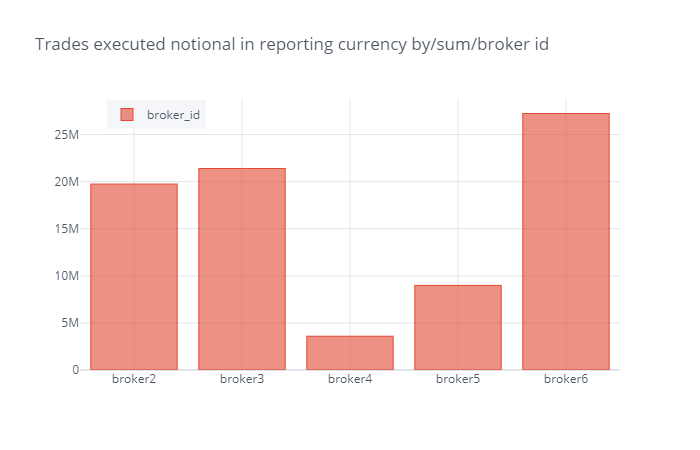

In [16]:
tca_results.bar_charts['trade_df_executed_notional_in_reporting_currency_by/sum/broker_id']

We can also show the DataFrame with the outlier trades, which are outside the bid/ask from Dukascopy data.

In [17]:
tca_results.table['trade_df_slippage_by_worst_all']

,executed_notional_in_reporting_currency,side,slippage_benchmark,slippage,slippage_anomalous
2017-05-08 10:31:33.011000+00:00,3.586887e+06,1,1.094680,-0.000021,1.0
2017-05-05 14:56:49.373000+00:00,6.811655e+06,1,1.098875,-0.000016,1.0
2017-05-08 14:37:25.382000+00:00,1.551467e+07,1,1.093750,-0.000015,1.0
2017-05-05 06:27:26.514000+00:00,1.976319e+07,-1,1.097445,-0.000013,1.0
2017-05-09 11:18:39.206000+00:00,1.293143e+07,-1,1.089700,-0.000013,1.0
Avg,1.463584e+07,0,1.094755,-0.000014,1.0


We can view the DataFrame for the combination of total amount executed per broker and the slippage (weighted by notional).

In [18]:
tca_results.join_tables['broker_id']

,broker_id notional (rep cur),broker_id slippage (bp)
broker2,19743083.0,-0.14
broker3,21398742.0,-0.11
broker4,3586887.0,-0.21
broker5,8986275.0,-0.10
broker6,27237125.0,-0.12


We can see the styled table, is a string of HTML code within an HTML IFrame. We could write this to disk as an HTML file or display to a user.

In [19]:
tca_results.styled_join_tables['broker_id']

Iframe(height='300px', sandbox='', srcDoc='<style></style>\n<table border="0">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>broker_id notional (rep cur)</th>\n      <th>broker_id slippage (bp)</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>broker2</th>\n      <td>19743083.0</td>\n      <td>-0.14</td>\n    </tr>\n    <tr>\n      <th>broker3</th>\n      <td>21398742.0</td>\n      <td>-0.11</td>\n    </tr>\n    <tr>\n      <th>broker4</th>\n      <td>3586887.0</td>\n      <td>-0.21</td>\n    </tr>\n    <tr>\n      <th>broker5</th>\n      <td>8986275.0</td>\n      <td>-0.10</td>\n    </tr>\n    <tr>\n      <th>broker6</th>\n      <td>27237125.0</td>\n      <td>-0.12</td>\n    </tr>\n  </tbody>\n</table>', width='975px', style={'border': 'thin lightgrey solid', 'padding': '0', 'margin': '0'})

# Conclusion

We have seen how to call tcapy programatically for more involved usage, in particular how to use it for compliance purposes.

If you are interesting supporting this project, such as sponsoring new features or to get commerical support, please contact saeed@cuemacro.com.